# Image Processing with scikit-image

In this notebook, we focus on **scikit-image**, a Python library **dedicated specifically to image processing**. We will cover:

- Reading images
- Image resizing and rescaling
- Edge detection using multiple algorithms
- Image deconvolution
- A real-world microscopy application: **scratch assay (wound healing) analysis**

---

## Why scikit-image?

Unlike SciPy or NumPy, **scikit-image** is designed entirely for image processing. It provides:

- Clean, readable APIs
- Well-documented algorithms
- Seamless NumPy integration
- Algorithms commonly used in microscopy and scientific imaging

---

## Reading Images

In [2]:
from skimage import io
import matplotlib.pyplot as plt

Read an image as grayscale:

Minimum pixel intensity: 0.0
Maximum pixel intensity: 1.0
Image shape: (294, 171). It means we have 294 pixeles vertically and 171 pixeles horizontally
Image type: float64. Image type is float64 due to type conversion to as_gray. Original image is `unit8`


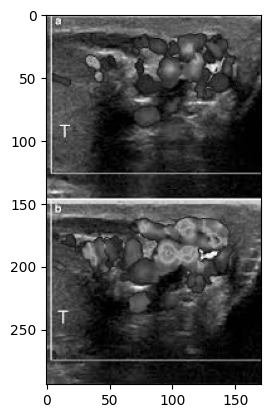

In [11]:
img = io.imread("doplerUS1.jpg", as_gray=True)

plt.imshow(img, cmap = "gray")

print(f"Minimum pixel intensity: {img.min()}")
print(f"Maximum pixel intensity: {img.max()}")
print(f"Image shape: {img.shape}. It means we have {img.shape[0]} pixeles vertically and {img.shape[1]} pixeles horizontally")
print(f"Image type: {img.dtype}. Image type is {img.dtype} due to type conversion to as_gray. Original image is `unit8`")

Key points:

- Images are loaded as NumPy arrays
- Grayscale images are stored as float64
- Pixel values are normalized between 0 and 1

---

## Image Resizing and Rescaling

All resizing operations are part of the skimage.transform module.

In [12]:
from skimage.transform import rescale, resize, downscale_local_mean

### 1. Rescaling

Rescaling changes image size by a scale factor.

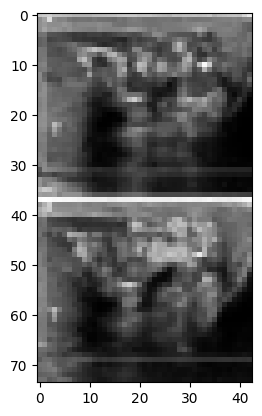

In [16]:
rescaled_img = rescale(img, 1.0 / 4.0, anti_aliasing=True)

plt.imshow(rescaled_img, cmap="gray")
plt.show()

- Maintains aspect ratio
- Anti-aliasing reduces visual artifacts

### 2. Resizing

Resizing forces an image into a specific shape.

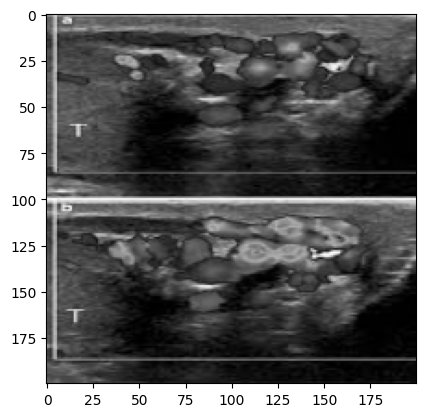

In [17]:
resized_img = resize(img, (200, 200), anti_aliasing=True)

plt.imshow(resized_img, cmap="gray")
plt.show()

### 3. Downscaling Using Local Mean

Downscaling reduces resolution by averaging pixel blocks.

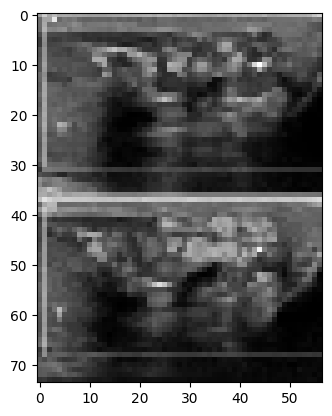

In [18]:
downscaled_img = downscale_local_mean(img, (4, 3))

plt.imshow(downscaled_img, cmap = "gray")
plt.show()

This often produces a pixelated appearance, which is expected.

---

## Edge Detection

Edge detection highlights *intensity transitions* in images. All classical edge filters are located in `skimage.filters`.

In [19]:
from skimage.filters import roberts, sobel, scharr, prewitt

### Applying Edge Filters:

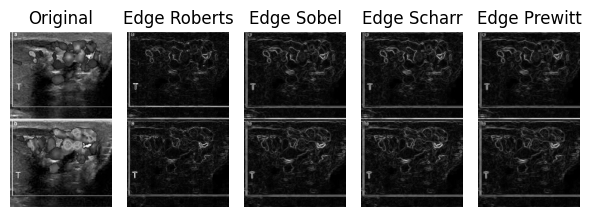

In [23]:
edge_roberts = roberts(img)
edge_sobel = sobel(img)
edge_scharr = scharr(img)
edge_prewitt = prewitt(img)

plt.figure(figsize=(6, 15))

plt.subplot(1, 5, 1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(edge_roberts, cmap="gray")
plt.title("Edge Roberts")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(edge_sobel, cmap="gray")
plt.title("Edge Sobel")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(edge_scharr, cmap="gray")
plt.title("Edge Scharr")
plt.axis("off")

plt.subplot(1, 5, 5)
plt.imshow(edge_prewitt, cmap="gray")
plt.title("Edge Prewitt")
plt.axis("off")

plt.tight_layout()
plt.show()


Each of these filters emphasizes edges differently depending on image structure.

### Canny Edge Detector

The Canny edge detector is more advanced and is found in `skimage.feature`.

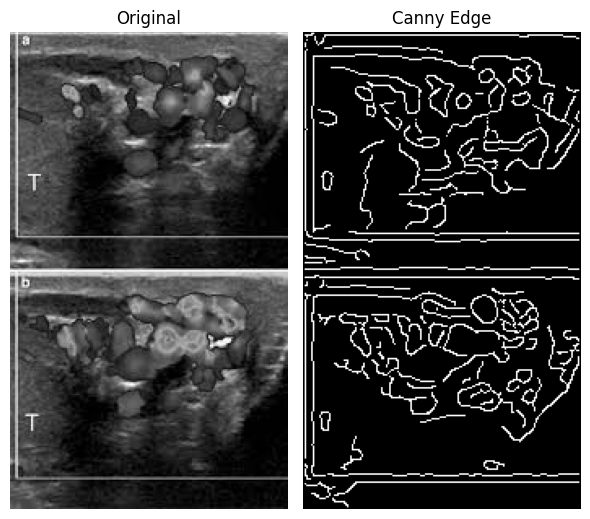

In [27]:
from skimage.feature import canny

edges = canny(img, sigma=2)

plt.figure(figsize=(6, 15))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap="gray")
plt.title("Canny Edge")
plt.axis("off")


plt.tight_layout()
plt.show()


Key characteristics:
- Output is a binary image
- Includes noise reduction, gradient calculation, and edge tracking
- `sigma` controls smoothing:
    - Low sigma → more edges (and noise)
    - High sigma → fewer edges

---

## Image Deconvolution
### What is Deconvolution?

In microscopy, images are blurred due to the point spread function (PSF) of the optical system. Deconvolution attempts to reverse this blur using an estimated PSF.

In practice:
- Commercial software uses precise microscope parameters
- Here, we demonstrate the concept using approximate PSFs.

### Deconvolution with scikit-image

In [28]:
from skimage import restoration
import numpy as np

### Simple PSF (Uniform Kernel)

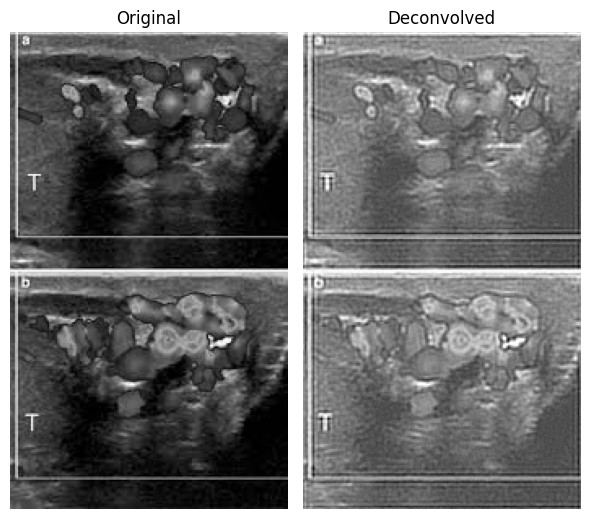

In [29]:
psf = np.ones((3, 3)) / 9
deconvolved = restoration.unsupervised_wiener(img, psf)[0]

plt.figure(figsize=(6, 15))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(deconvolved, cmap="gray")
plt.title("Deconvolved")
plt.axis("off")


plt.tight_layout()
plt.show()

This sharpens the image while preserving overall intensity.

### Gaussian PSF Example

A more realistic PSF can be modeled using a Gaussian kernel.

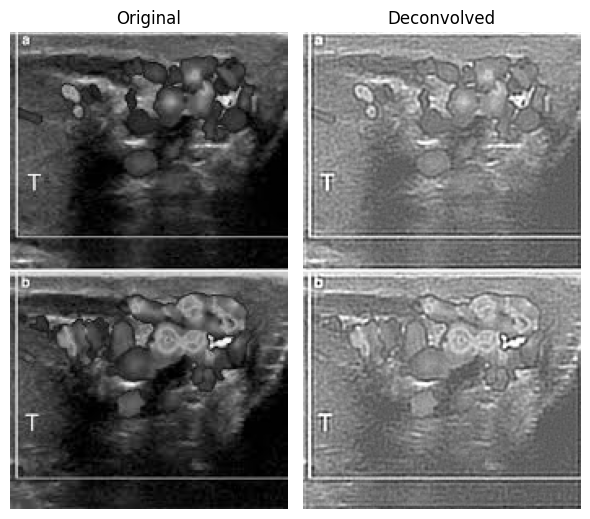

In [31]:
import scipy.stats as st

def gaussian_kernel(size, sigma):
    ax = np.linspace(-(size // 2), size // 2, size)
    gauss = st.norm.pdf(ax, scale=sigma)
    kernel = np.outer(gauss, gauss)
    return kernel / kernel.sum()

psf = gaussian_kernel(5, 1)
deconvolved = restoration.unsupervised_wiener(img, psf)[0]

plt.figure(figsize=(6, 15))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(deconvolved, cmap="gray")
plt.title("Deconvolved")
plt.axis("off")


plt.tight_layout()
plt.show()

### Real-World Example: Scratch Assay (Wound Healing) Analysis
**What Is a Scratch Assay?**

In a scratch assay:
- Cells are grown on a surface
- A "scratch" is created manually
- Images are taken over time 
- The closure of the scratch is quantified

The goal is to measure healing rate, typically by computing the area of the scratch over time.

**Problem Overview**

The challenge:

- Scratched and cell-covered regions often have similar mean intensity
- Simple thresholding fails
- Texture-based segmentation is required

**Texture-Based Segmentation Using Entropy**   
**Why Entropy?**

Entropy measures local disorder:
- Flat regions → low entropy
- Cell-rich regions → high entropy

This makes entropy ideal for scratch assay segmentation.

### Computing Entropy

In [32]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

In [ ]:
scratch = io.imread("images/scratch.jpg", as_gray=True)
entropy_img = entropy(scratch, disk(3))